# 0. Introduction

- Датасет взят отсюда: https://media.xiph.org/video/derf/. RnD по видеокомпрессии он часто используется для бенчмаркинга алгоритмов. Внизу web-страницы есть разные варианты датасетов, для тестов был взят objective-1-fast. 

- Датасет представляет собой выборку из коротких видео ($~10^2$ фреймов) с разными разрешениями. В них, как правило, нет смены сцены, а значит, можно упростить задачу при тестировании различных подходов для видеокомпрессии. 

- Данные в raw формате yuv420 (.y4m, в отличии от .yuv, есть хэдер с метаданными). Ссылки: https://ru.wikipedia.org/wiki/YUV, 

- Используется opencv-python для загрузки-обработки-сохранения видео.

- В качестве backend-а для i/o используется библиотека ffmpeg. Бинарники для Windows лежат в корне проекта. Для Linux-а нужно ставить отдельно.

- Тензорные разложения делаются с помощью of-the-shelf имплементаций из библиотеки tensorly. Из плюсов, она может использовать PyTorch в качестве backend-a => Можно проводить расчеты на GPU (не реализовано). UPD Реализован налитический подбор рангов TTSVD и HOSVD с использованием нормы Фробениуса. Базовая реализация TTSVD и HOSVD(Tucker) адаптирована из следующей работы: https://github.com/azamat11235/NLRTA


- На текущий момент не было найдено способа сохранять видео обратно в .y4m. Для этого нужно разбираться с CLI ffmpeg (его обертка в opencv этого сделать не позволяет). В текущей реализации, для корректной работы необходимо использовать расширение .avi для сохраняемого файла. При этом формат хранения фреймов видео останется прежним. Следует учитывать, что при конверсии yuv420 - RGB24 - yuv420 есть незначительные потери. Они минимальны и не влияют существенно на результат.

# 1. IO and Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

In [2]:
LOAD_FNAME = "data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.y4m"
SAVE_FNAME = "compressed_data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.avi"

### 1.1. Downloading the video to numpy array

In [3]:
from cvtcomp.io import load_video_to_numpy

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

In [4]:
video.shape

(60, 1080, 1920, 3)

 Fourcc of raw video can be accessed as follows. https://en.wikipedia.org/wiki/FourCC

In [5]:
import struct
print("FOURCC is '%s'" % struct.pack("<I", int(fourcc)))

FOURCC is 'b'I420''


### 1.2. Vizualization

In [6]:
from cvtcomp.utils import play_video

%matplotlib inline

play_video(video, fps=20)

### 1.3. Saving the video in raw format

In [7]:
from cvtcomp.io import save_video_from_numpy

save_video_from_numpy(SAVE_FNAME, video, fourcc, fps, size, color=True)

### 1.4. Checking the losses during the saveing/loading

Следует учитывать, что есть потери при конверсии y4m -> rgb24 -> y4m 

In [8]:
video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
save_video_from_numpy(SAVE_FNAME, video, fourcc, fps, size, color=True)
video_new, _, _, _ = load_video_to_numpy(SAVE_FNAME) 

print(f"RMSE: {(((video_new - video)**2).sum() / video_new.size)**0.5}")

RMSE: 2.067145082840086


In [9]:
from cv2 import PSNR

print(f"PSNR = {PSNR(video_new, video)} dB")

video.shape

PSNR = 41.82338443447218 dB


(60, 1080, 1920, 3)

# 2. Testing the Videocompression algorithms based on Tensor Decompositions

In [1]:
LOAD_FNAME = "data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.y4m"
COMPRESSED_VIDEO_FNAME = 'compressed_data/compressed_video.ctv'

## 2.1 Tucker Decomposition

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

tensor_video = TensorVideo(
    compression_type='tucker',
    quality=30.0,
    chunk_size=30,
    decoded_data_type=np.uint8,
    verbose=True)

tensor_video.encode(video)

restored_video = tensor_video.decode()

ValueError: too many values to unpack (expected 2)

In [3]:
play_video(video, fps=fps / 2)

In [4]:
play_video(restored_video, fps=fps / 2)

In [5]:
from cv2 import PSNR
import os
print(tensor_video.encoded_data[0][0].shape)
print(f" CR: { 1 / (tensor_video.encoded_data_size / os.path.getsize(LOAD_FNAME))}, PSNR: {PSNR(video, restored_video)}") 

(15, 157, 284, 3)
 CR: 5.755645067872567, PSNR: 30.155402997130388


### Framewise video saving

In [26]:
import cv2
import os
FOLDER_TO_SAVE = "video_frames"

os.makedirs(FOLDER_TO_SAVE, exist_ok=True)

for ii in range(0, 60, 6):
    cv2.imwrite(
        f"{FOLDER_TO_SAVE}/{ii}_original.png",
        cv2.cvtColor(video[ii,:, :, :], cv2.COLOR_RGB2BGR),
        [int(cv2.IMWRITE_PNG_COMPRESSION), 0]
        
    )
    
    cv2.imwrite(
        f"{FOLDER_TO_SAVE}/{ii}_restored.png",
        cv2.cvtColor(restored_video[ii,:, :, :], cv2.COLOR_RGB2BGR),
        [int(cv2.IMWRITE_PNG_COMPRESSION), 0]
        
    )

### 2.2 TT-SVD

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

tensor_video = TensorVideo(compression_type='tt', quality=21.0, chunk_size=20, decoded_data_type=np.uint8)

tensor_video.encode(video)

restored_video = tensor_video.decode()

In [112]:
play_video(video, fps=fps / 2)

In [113]:
play_video(restored_video, fps=fps / 2)

In [114]:
from cv2 import PSNR
import os

print(f" CR: { 1 / tensor_video.encoded_data_size * os.path.getsize(LOAD_FNAME)}, PSNR: {PSNR(video, restored_video)}") 

 CR: 2.7284243209568553, PSNR: 28.153217527048685


In [115]:
10 * np.log10(255**2 / ((video.astype(np.float32) - restored_video.astype(np.float32))**2).mean())

28.15323353423757

In [116]:
video.shape

(60, 1080, 1920, 3)

### 2.3 Checking the approach with the reference frame substraction and compression of residuals


Подход вычитанием опорного кадра и компрессии остатков используется в h264 кодеке. Следует проверить, улучшит ли он качество видео при сжатии для используемых форматов хранения сжатого видео

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video, delete_reference_frame, restore_from_reference_frame
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
substracted_video, ref_frame = delete_reference_frame(video)

tensor_video = TensorVideo(compression_type='tucker', quality=25.0, chunk_size=20, decoded_data_type=np.uint8)
tensor_video.encode(substracted_video)


restored_video = restore_from_reference_frame(tensor_video.decode(), ref_frame)

play_video(restored_video, fps= fps/2)

- Оба подхода работают 
- "Наивная" реализация подхода с компрессией остатков не принесла желаемого результата

### 2.3 Saving the video in the compressed format

In [24]:
tensor_video.save(COMPRESSED_VIDEO_FNAME, fps=30)

### 2.4 Loading the video from the compressed format

In [25]:
loaded_tensor_video = TensorVideo().load(COMPRESSED_VIDEO_FNAME)
play_video(loaded_tensor_video.decode(), fps = loaded_tensor_video.fps / 2) # в данном случае загружаем закодированные остатки

## 3. Algorithm performance estimation for the complete dataset

In [1]:
from cvtcomp.utils import compute_metrics_dataset
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video


def get_metrics_different_qualities(folderpath, compression_type='tt', chunk_size=30, qs=[5.0, 10.0, 20.0, 25.0]):
    
    result = np.array([compute_metrics_dataset(folderpath,
                                                   compression_type=compression_type,
                                                   chunk_size=chunk_size,
                                                   quality=q) for q in qs])
    
    return result[:, 0], result[:, 1], result[:, 2] # CR, PSNR, SSIM

In [8]:
# Получаем  СR, PSNR, SSIM для одного значения quality
compute_metrics_dataset("data/", compression_type='tucker', chunk_size=30, quality=30.)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [45:13<00:00, 90.45s/it]


(0.46811498647181093, 30.353146526448562, 0.8635940065898775)

In [22]:
cr_tt, psnr_tt, ssim_tt = get_metrics_different_qualities(
    'data/',
    compression_type='tt',
    chunk_size=30,
    qs=[5.0, 10.0, 20.0, 25.0, 30.0]
)

print(f"cr_tt: {cr_tt}\n psnr_tt: {psnr_tt}, \n ssim_tt: {ssim_tt}")

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:30:48<00:00, 181.61s/it]


cr_tt: [1.60904947e-04 2.81804038e-03 1.56176618e-01 5.28864071e-01
 1.25632606e+00]
 psnr_tt: [15.44509748 16.7193326  23.46841186 26.51888692 31.41276161], 
 ssim_tt: [0.43187077 0.46151141 0.75413323 0.86995214 0.94103364]


In [2]:
cr_tucker, psnr_tucker, ssim_tucker = get_metrics_different_qualities(
    'data/',
    compression_type='tucker',
    chunk_size=30,
    qs=[5.0, 10.0, 20.0, 25.0, 35.0]
)

print(f"cr_tucker: {cr_tucker}\n psnr_tucker: {psnr_tucker} \n ssim_tucker: {ssim_tucker}")

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [53:13<00:00, 106.46s/it]

cr_tucker: [1.50915068e-04 1.65184323e-04 9.69352785e-03 8.55899236e-02
 1.38083472e+00]
 psnr_tucker: [15.41278195 15.42550181 20.64580562 25.36196122 35.50477082] 
 ssim_tucker: [0.43120755 0.43144023 0.56207473 0.72787337 0.94222314]


In [11]:
ssim_h264 = 0.828920385
cr_h264 = 0.007438296
psnr_h264 = 29.37835946

#### CR - PSNR

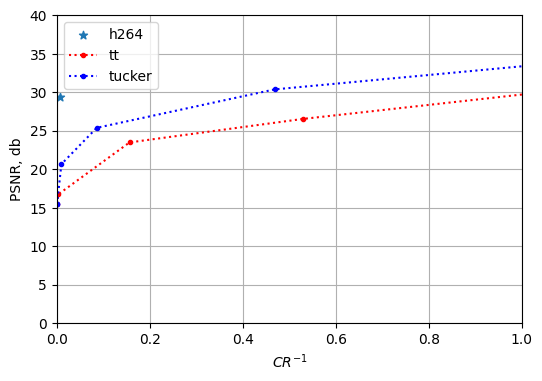

In [12]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 40])
plt.xlabel("$CR^{-1}$")
plt.ylabel("PSNR, db")
plt.scatter(cr_h264, psnr_h264, marker='*', label="h264")
plt.plot(cr_tt, psnr_tt, "r:.", label="tt")
plt.plot(cr_tucker, psnr_tucker, "b:.", label="tucker")
plt.legend()

#### CR - SSIM

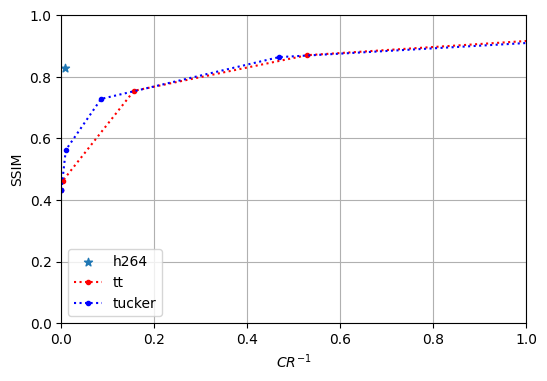

In [13]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("$CR^{-1}$")
plt.ylabel("SSIM")

plt.scatter(cr_h264, ssim_h264, marker='*', label="h264")
plt.plot(cr_tt, ssim_tt, "r:.", label="tt")
plt.plot(cr_tucker, ssim_tucker, "b:.", label="tucker")
plt.legend()

#  3.3 Tests of other hypotheses

### 3.2.1 Compression performans for videos with different resolutions (4К and 720p)

In [4]:
TEST_FILEPATH = r"data/large/4K/Netflix_Aerial_4096x2160_60fps_10bit_420_60f.y4m"
FOLDERPATH_4K = "data/large/4K/"
FOLDERPATH_720p = "data/large/720p/"
FOLDERPATH_360p = "data/large/360p/"

#### Проверяем, что достаточно вычислительных ресурсов

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

video, fourcc, fps, size = load_video_to_numpy(TEST_FILEPATH)

tensor_video = TensorVideo(compression_type='tucker', quality=20.0, chunk_size=20, decoded_data_type=np.uint8)

tensor_video.encode(video)

restored_video = tensor_video.decode()

In [10]:
play_video(video, fps=fps / 2)

In [11]:
play_video(restored_video, fps=fps / 2)

In [12]:
from cv2 import PSNR
import os

print(f" CR: { tensor_video.encoded_data_size / os.path.getsize(TEST_FILEPATH)}, PSNR: {PSNR(video, restored_video)}") 

 CR: 0.0001163510617638458, PSNR: 18.55949821795421


In [13]:
tensor_video.encoded_data[0][0].shape

(1, 4, 2, 3)

#### Подсчет метрик для видео в разном разрешении по всему датасету

In [6]:
cr_tucker_360p, psnr_tucker_360p, ssim_tucker_360p = get_metrics_different_qualities(
    FOLDERPATH_360p,
    compression_type='tucker',
    chunk_size=20,
    qs=[20.0, 25.0, 30.0]
)

print(f"cr_tucker: {cr_tucker_360p}\n psnr_tucker: {psnr_tucker_360p} \n ssim_tucker: {ssim_tucker_360p}")

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [02:45<00:00, 11.84s/it]

cr_tucker: [0.01583214 0.16049255 0.71418681]
 psnr_tucker: [21.06971973 25.77708143 30.48663123] 
 ssim_tucker: [0.56927395 0.77410329 0.89003895]


In [7]:
cr_tucker_4k, psnr_tucker_4k, ssim_tucker_4k = get_metrics_different_qualities(
    FOLDERPATH_4K,
    compression_type='tucker',
    chunk_size=20,
    qs=[20.0, 25.0, 30.0]
)

print(f"cr_tucker: {cr_tucker_4k}\n psnr_tucker: {psnr_tucker_4k} \n ssim_tucker: {ssim_tucker_4k}")

100%|██████████████████████████████████████████████████████████████████████████████| 14/14 [7:59:09<00:00, 2053.54s/it]


cr_tucker: [0.00208298 0.01305903 0.05693591]
 psnr_tucker: [20.83862165 25.45386981 30.43369235] 
 ssim_tucker: [0.55550354 0.71054267 0.84705401]


 Умножаем на 10/8 чтобы учесть битность (10bit для 4K и 8bit для 360p).

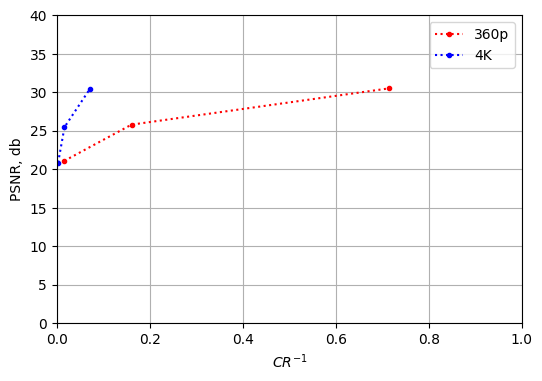

In [20]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 40])
plt.xlabel(r"$CR^{-1}$")
plt.ylabel("PSNR, db")
plt.plot(cr_tucker_360p, psnr_tucker_360p, "r:.", label="360p")
plt.plot(cr_tucker_4k * (10 / 8), psnr_tucker_4k, "b:.", label="4K")
plt.legend()

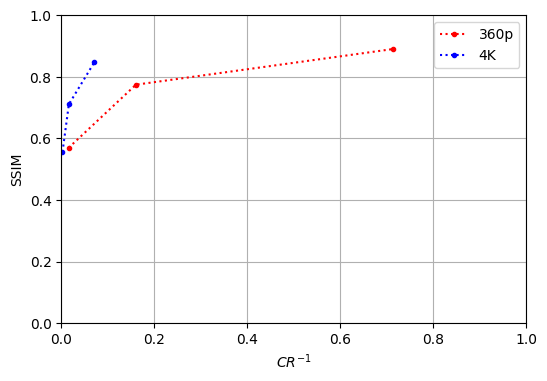

In [19]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r"$CR^{-1}$")
plt.ylabel("SSIM")
plt.plot(cr_tucker_360p, ssim_tucker_360p, "r:.", label="360p")
plt.plot(cr_tucker_4k * (10 / 8), ssim_tucker_4k, "b:.", label="4K")
plt.legend()

In [13]:
print(f"cr_tucker: {cr_tucker_4k * 10 / 8}\n psnr_tucker: {psnr_tucker_4k} \n ssim_tucker: {ssim_tucker_4k}")

cr_tucker: [0.00260372 0.01632379 0.07116989]
 psnr_tucker: [20.83862165 25.45386981 30.43369235] 
 ssim_tucker: [0.55550354 0.71054267 0.84705401]


# 3.2.3 Quantization

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from cv2 import PSNR
from cvtcomp.base import TensorVideo
from cvtcomp.io import load_video_to_numpy
from cvtcomp.utils import play_video
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'

LOAD_FNAME = "data/Netflix_PierSeaside_1920x1080_60fps_8bit_420_60f.y4m"

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)


#tensor_video = TensorVideo(compression_type='tt', quality=21.0, chunk_size=20, decoded_data_type=np.uint8)

#tensor_video.encode(video)

#restored_video = tensor_video.decode()

def get_cr_psnr_reshaped(fname, new_shape, chunk_size=30, qs=[10.0, 15.0, 20.0, 25.0]):
    
    results = []
    video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
    
    video_reshaped = video.reshape(new_shape)
    
    for q in qs:
        
        tensor_video_reshaped = TensorVideo(compression_type='tt', quality=q, chunk_size=chunk_size, decoded_data_type=np.uint8)
        tensor_video_reshaped.encode(video_reshaped)
        video_reshaped_restored = (tensor_video_reshaped.decode()).reshape(video.shape)

        results.append([1 / tensor_video_reshaped.encoded_data_size * os.path.getsize(fname),
                        PSNR(video, video_reshaped_restored)])
        
    return np.array(results)


def get_cr_psnr(fname, chunk_size=30, qs=[10.0, 15.0, 20.0, 25.0], compression_type="tt"):
    
    results = []
    video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
    
    for q in qs:
        tensor_video = TensorVideo(compression_type=compression_type, quality=q, chunk_size=chunk_size, decoded_data_type=np.uint8)
        tensor_video.encode(video)
        video_restored = (tensor_video.decode())

        results.append([1 / tensor_video.encoded_data_size * os.path.getsize(fname),
                        PSNR(video, video_restored)])
        
    return np.array(results)

In [6]:
new_shape = (60, 36, 30, 32, 60, 3)
qs = [10.0, 15.0, 20.0, 25.0, 30.0]

result = get_cr_psnr(LOAD_FNAME, chunk_size=60, qs=qs, compression_type="tt")
result_tucker = get_cr_psnr(LOAD_FNAME, chunk_size=60, qs=qs + [35, ], compression_type="tucker")
result_reshaped = get_cr_psnr_reshaped(LOAD_FNAME, new_shape, chunk_size=60, qs=qs)
print(result)
print(result_tucker)
print(result_reshaped)

[[1.52321596e+04 1.72092685e+01]
 [6.11779041e+02 2.06937907e+01]
 [1.12933065e+01 2.64443842e+01]
 [1.88186473e+00 3.10239425e+01]
 [6.76351786e-01 3.67109633e+01]]
[[1.52271883e+04 1.72092684e+01]
 [1.52271883e+04 1.72092684e+01]
 [3.01688361e+03 2.03820021e+01]
 [7.70959930e+01 2.50784437e+01]
 [5.37537688e+00 3.00799850e+01]
 [1.15900720e+00 3.50494565e+01]]
[[1.92873522e+04 1.90307848e+01]
 [1.33741064e+02 2.33002343e+01]
 [7.56447690e+00 2.78358471e+01]
 [1.66671483e+00 3.23725192e+01]
 [6.87613993e-01 3.81684667e+01]]


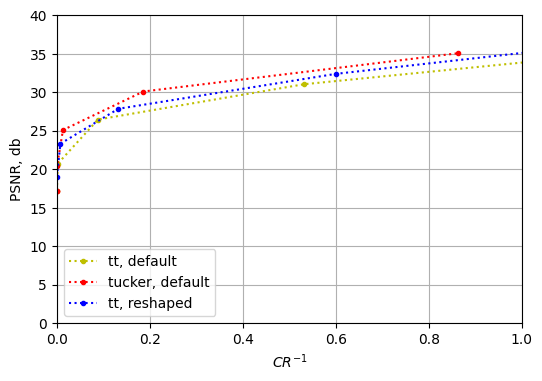

In [7]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 40])
plt.xlabel(r"$CR^{-1}$")
plt.ylabel("PSNR, db")
plt.plot(1 / result[:, 0], result[:, 1] , "y:.", label="tt, default")
plt.plot(1 / result_tucker[:, 0], result_tucker[:, 1] , "r:.", label="tucker, default")
plt.plot(1 / result_reshaped[:, 0], result_reshaped[:, 1] , "b:.", label="tt, reshaped")
plt.legend()

In [ ]:
video_quantized = video.reshape()

In [19]:
print(1080**0.5)
print(1920**0.5)

32.863353450309965
43.81780460041329


In [21]:
1080 / 30

36.0

In [23]:
1920 / 60

32.0

In [2]:
video.size / 2**12 / 5**3 / 3**6

2**2 * 3

new_shape = (4 * 5, 4 * 5, 4 * 5, 4 * 9, 4 * 9, 4 * 9)
new_shape = (60, 36, 30, 32, 60, 3)
new_shape

(60, 36, 30, 32, 60, 3)

In [3]:
video_reshaped = video.reshape(new_shape)

tensor_video_reshaped = TensorVideo(compression_type='tt', quality=20.0, chunk_size=60, decoded_data_type=np.uint8)

tensor_video_reshaped.encode(video_reshaped)

video_reshaped_restored = (tensor_video_reshaped.decode()).reshape(video.shape)

play_video(video_reshaped_restored)

In [5]:
from cv2 import PSNR
import os

print(f" CR: { 1 / tensor_video_reshaped.encoded_data_size * os.path.getsize(LOAD_FNAME)}, PSNR: {PSNR(video, video_reshaped_restored)}") 

 CR: 7.564476903396516, PSNR: 27.83584705341664


In [78]:
[x.shape for x in tensor_video_reshaped.encoded_data[0]]

[(1, 60, 32), (32, 36, 348), (348, 30, 204), (204, 32, 11), (11, 180, 1)]